### load dicom data

In [1]:
from glob import glob

data_path = 'C:/Users/dDk13/Desktop/ddk_test/PointCloudTest/data/manekin_data'
output_path = working_path = '01_export_data/'
g = glob(data_path + '/*.dcm')

# Print out the first 5 file names to verify we're in the right folder.
print("Total of %d DICOM images.\nFirst 5 filenames:" % len(g))
print('\n'.join(g[:5]))

Total of 397 DICOM images.
First 5 filenames:
C:/Users/dDk13/Desktop/ddk_test/PointCloudTest/data/manekin_data\CT_003.dcm
C:/Users/dDk13/Desktop/ddk_test/PointCloudTest/data/manekin_data\CT_004.dcm
C:/Users/dDk13/Desktop/ddk_test/PointCloudTest/data/manekin_data\CT_005.dcm
C:/Users/dDk13/Desktop/ddk_test/PointCloudTest/data/manekin_data\CT_006.dcm
C:/Users/dDk13/Desktop/ddk_test/PointCloudTest/data/manekin_data\CT_007.dcm


### save data (format : .npy)

In [3]:
import numpy as np
import dicom
import os

#      
# Loop over the image files and store everything into a list.
# 

def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=5):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

id=0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

c:\users\ddk13\appdata\local\programs\python\python36\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


### load .npy data from dicom

In [4]:
imgs_dicom_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

In [5]:
num_of_dicom_data = len(imgs_dicom_to_process)

### make CT boundary mask : with canny

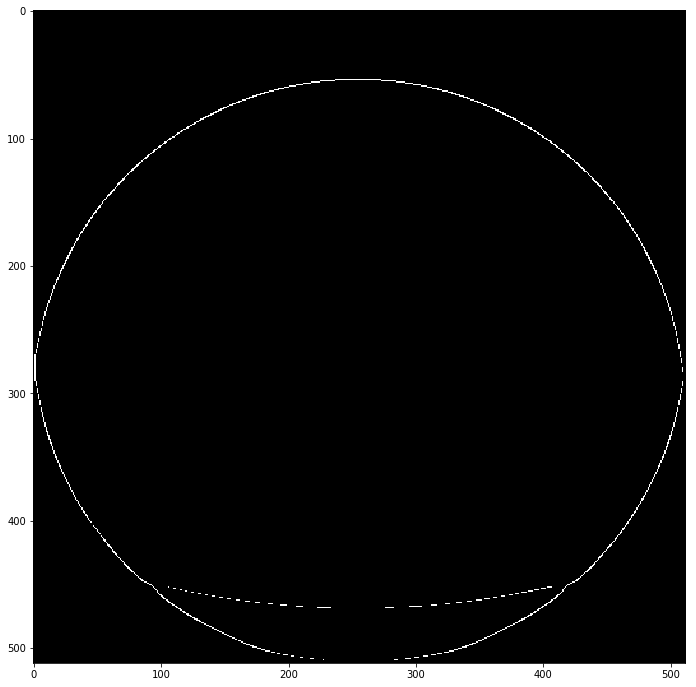

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import feature

CT_boundary_datas = []

for i in range(num_of_dicom_data):
    if(i % int(num_of_dicom_data/8) == 0):
        img_tmp = imgs_dicom_to_process[i]
        edges_tmp = feature.canny(
            image=img_tmp,
            sigma=3,
            low_threshold=-1000,
            high_threshold=1000,
        )
        CT_boundary_datas.append(edges_tmp)
    
CT_boundary_data_canny = 0
    
for i in range(len(CT_boundary_datas)):
    if(i == 0):
        CT_boundary_data_canny = CT_boundary_datas[0]
    else:
        CT_boundary_data_canny = CT_boundary_data & CT_boundary_datas[i]

fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(CT_boundary_data_canny, cmap='gray')
plt.show()

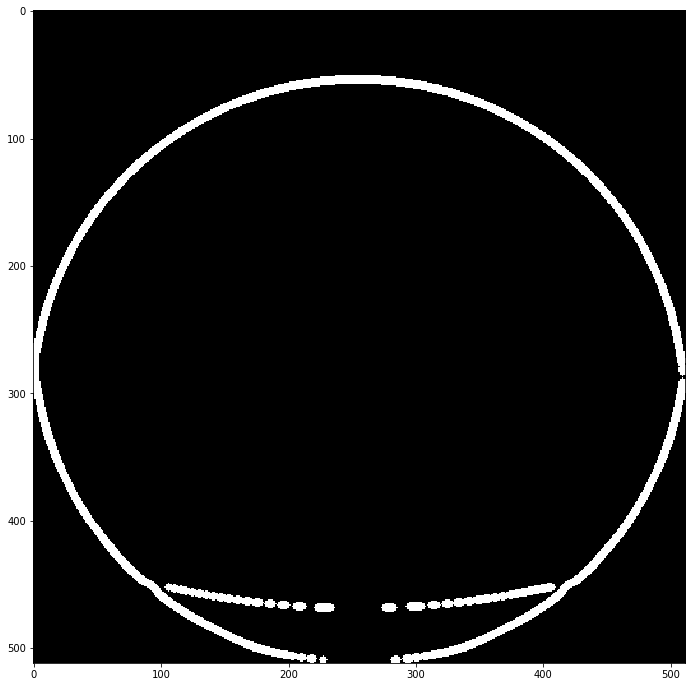

In [70]:
from skimage import morphology

from skimage.morphology import disk

selem = disk(3)

test_img = morphology.dilation(CT_boundary_data_canny, selem)

fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(test_img, cmap='gray')
plt.show()

### make CT boundary each mask : with dilation

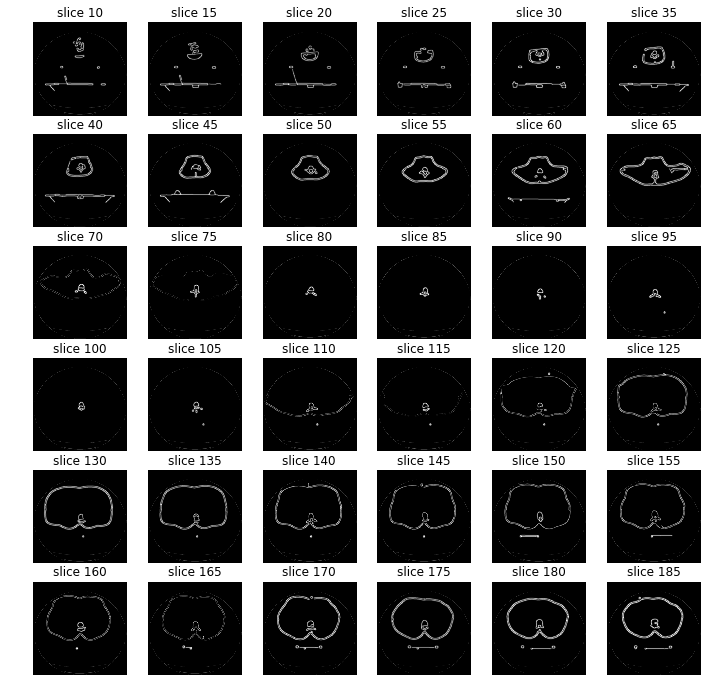

In [48]:
from scipy.ndimage import gaussian_filter
from skimage import img_as_float
from skimage.morphology import reconstruction

CT_data_canny_dilated_diff = []


for i in range(num_of_dicom_data):
    img_tmp = imgs_dicom_to_process[i]
    
    edges_tmp = feature.canny(
        image=img_tmp,
        sigma=3,
        low_threshold=-1000,
        high_threshold=1000,
    )
        
    image = img_as_float(edges_tmp)
    image = gaussian_filter(image, 2)

    seed = np.copy(image)
    seed[1:-1, 1:-1] = image.min()
    mask = image

    dilated = reconstruction(seed, mask, method='dilation')

    dilated_diff_tmp = image - dilated
    CT_data_canny_dilated_diff.append(dilated_diff_tmp)

sample_stack(CT_data_canny_dilated_diff)

### make abdomen mask : with binary filling

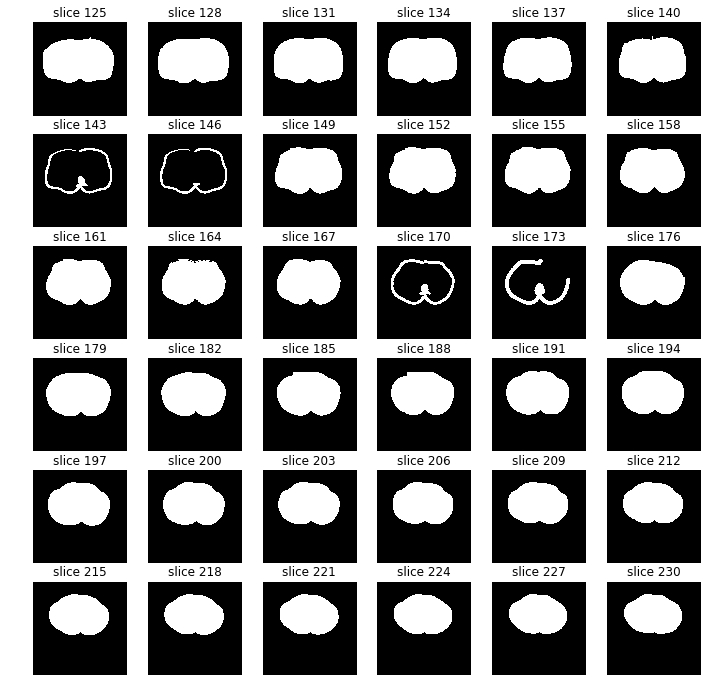

In [55]:
from scipy import ndimage as ndi

CT_abdomen_masks_canny_dilated_diff_bn_filling = []

for i in range(num_of_dicom_data):
    bn_filling_tmp = ndi.binary_fill_holes(CT_data_canny_dilated_diff[i])
    label_objects, nb_labels = ndi.label(bn_filling_tmp)
    sizes = np.bincount(label_objects.ravel())
    
    sizes[0] = 0
    mask_sizes = sizes > (sizes.max() - 2000)
    
    abdomen_bn_filling_cleaned_tmp = mask_sizes[label_objects]
    
    CT_abdomen_masks_canny_dilated_diff_bn_filling.append(abdomen_bn_filling_cleaned_tmp)

sample_stack(CT_abdomen_masks_canny_dilated_diff_bn_filling, start_with = 125, show_every=3)

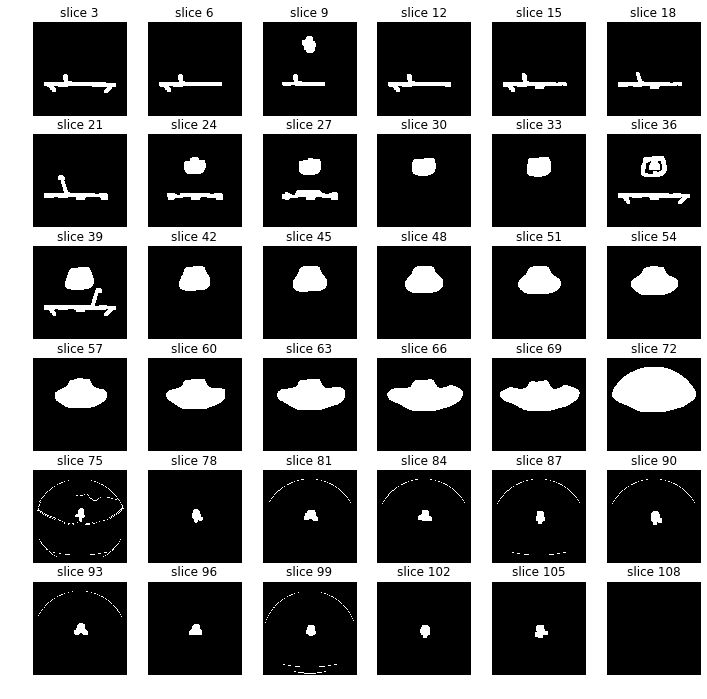

In [57]:
sample_stack(CT_abdomen_masks_canny_dilated_diff_bn_filling, start_with = 3, show_every=3)

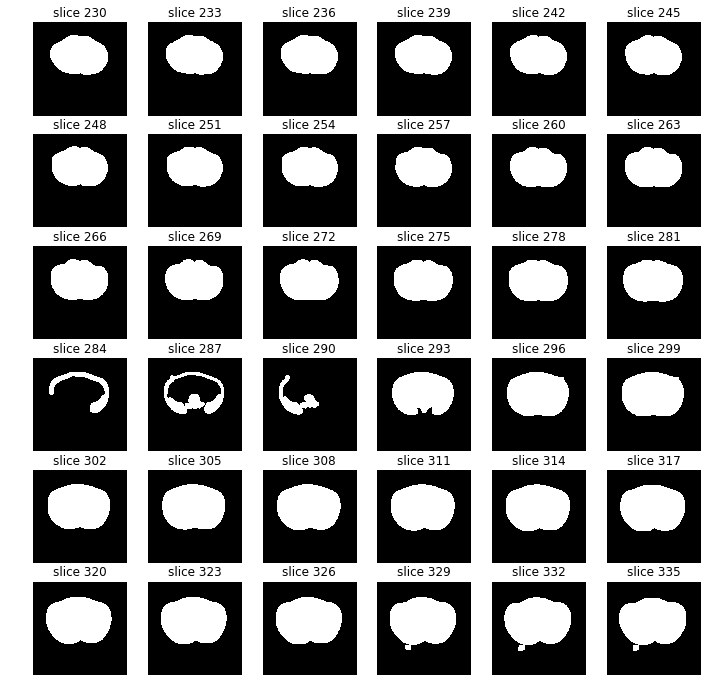

In [56]:
sample_stack(CT_abdomen_masks_canny_dilated_diff_bn_filling, start_with = 230, show_every=3)

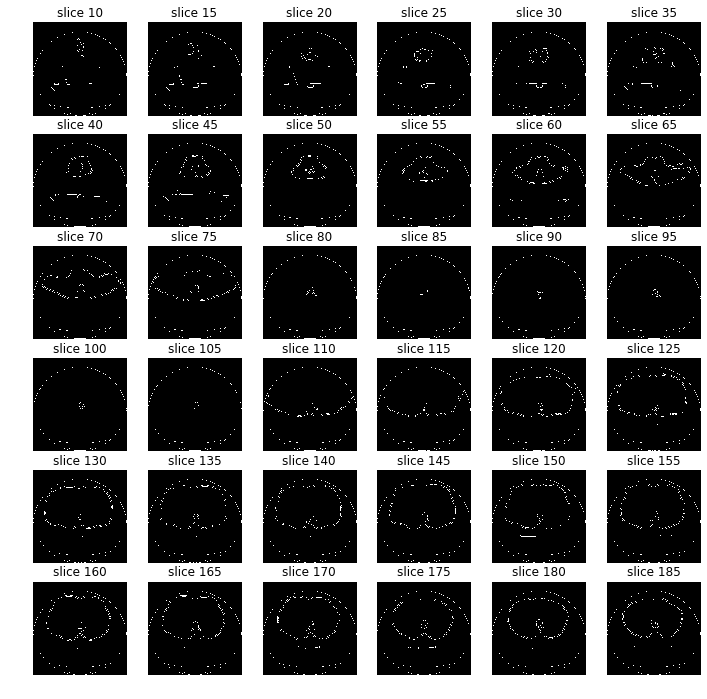

In [52]:
edges_ = []

for i in range(num_of_dicom_data):
    img_tmp = imgs_dicom_to_process[i]
    
    edges_tmp = feature.canny(
        image=img_tmp,
        sigma=3,
        low_threshold=0,
        high_threshold=1000,
    )
    
    edges_.append(edges_tmp)
    
sample_stack(edges_)

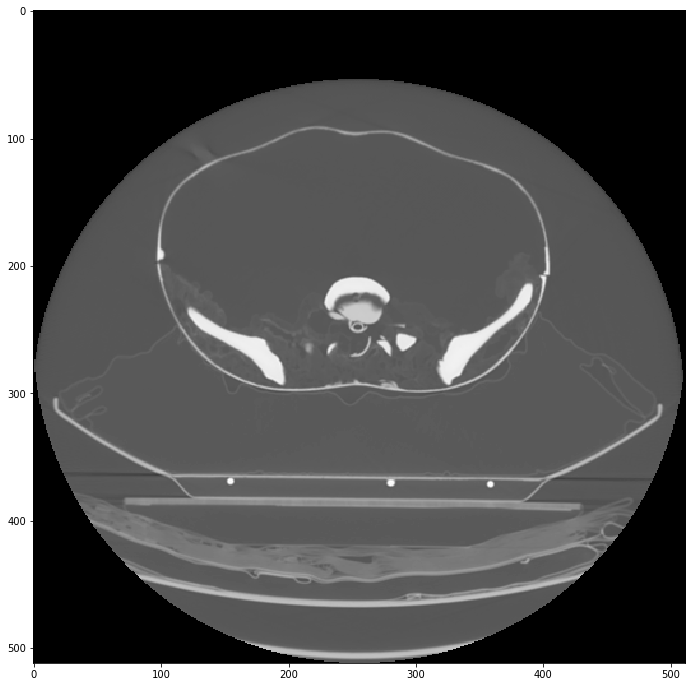

In [61]:
from skimage import exposure

#img_eq = exposure.equalize_hist(img)

#img_test = exposure.equalize_hist(imgs_dicom_to_process[284])
img_test = imgs_dicom_to_process[284]

edges_test = feature.canny(
    image=img_test,
    sigma=3,
    low_threshold=-1000,
    high_threshold=1000,
)

fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(img_test, cmap='gray')
plt.show()

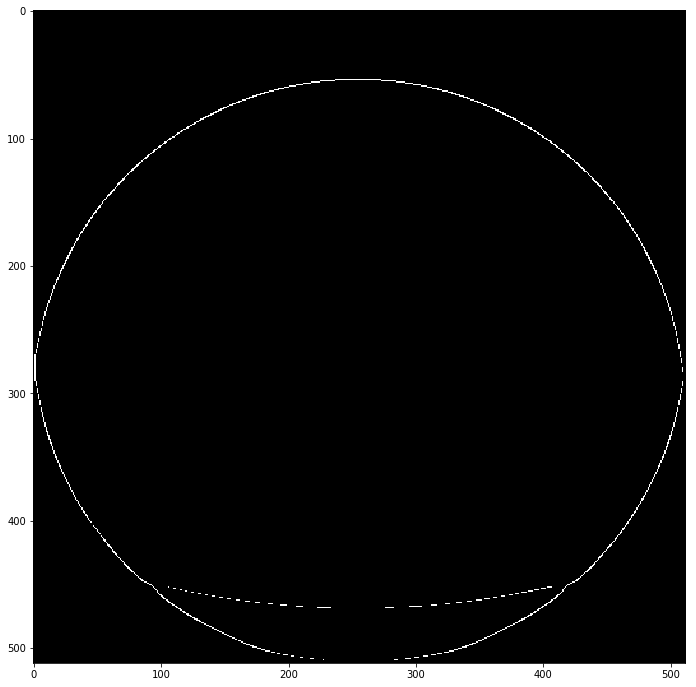

In [63]:

bn_filling_tmp = ndi.binary_fill_holes(CT_boundary_data_canny)

label_objects, nb_labels = ndi.label(bn_filling_tmp)
sizes = np.bincount(label_objects.ravel())

sizes[0] = 0
mask_sizes = sizes > (sizes.max() - 2000)

abdomen_bn_filling_cleaned_tmp = mask_sizes[label_objects]

fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(CT_boundary_data_canny, cmap='gray')
plt.show()
